# Reproducing results

Since we rebuild SCINet from scratch, it is necessary to test and compare with the original Pytorch implementation to see whether everything functions as expected. To that end, our goal in this notebook is to replicate some of the result posed in the original paper. As such, the goal is not necessary to get as good of a score on the dataset as possible, but rather to get a similar score to the original SCINet.

As alway, we will begin by importing some of the relevant libraries:

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR) #add base to path for relative imports
os.chdir('../..')



Since the loading-preprocessing-training workflow has already been thoroughly discussed before ('exp/training_scinet.ipynb'), we will do it all at once. For the datasets to compare, we will use the 'experiment_ETTh1','experiment_ETTh2' and 'experiment_ETTM1' datasets. The hyperparameters used are similar to those described in the original paper.

In [5]:
from preprocess_data import preprocess
from base.train_scinet import train_scinet
from utils.data_loading import load_data
from utils.original_hyperparameters import orig_param

datasets = ['ETTh1']

X_len = 48
Y_len = 24

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

standardization_settings = {'per_sample': False,
                            'leaky': False,
                            'mode': 'lin', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

for dataset in datasets:

    data = load_data(dataset , pairs)

    proc_results = preprocess(   
                        data = data, 
                        symbols = pairs,
                        data_format = ['price'],
                        fraction = 1,
                        train_frac = .6,
                        val_frac = .2,
                        test_frac = .2,
                        X_LEN = X_len,
                        Y_LEN = Y_len,
                        OVERLAPPING = True,
                        STANDARDIZE = True,
                        standardization_settings = standardization_settings
                        )

    results = train_scinet( 
                    X_train = proc_results["X_train"],
                    y_train = proc_results["y_train"],
                    X_val = proc_results["X_val"],
                    y_val = proc_results["y_val"],
                    X_test = proc_results["X_test"],
                    y_test = proc_results["y_test"],
                    epochs = 2,
                    batch_size = orig_param[dataset]['batch_size'],
                    X_LEN = X_len,
                    Y_LEN = [Y_len],
                    output_dim = [proc_results["X_train"].shape[2]],
                    selected_columns = None,
                    hid_size= orig_param[dataset]['hid_size'],
                    num_levels= orig_param[dataset]['num_levels'],
                    kernel = orig_param[dataset]['kernel_size'],
                    dropout = orig_param[dataset]['dropout'],
                    loss_weights= [1],
                    learning_rate = orig_param[dataset]['lr_rate'],
                    probabilistic = False)

    results[0].save_weights('saved_models/model_{}.h5'.format(dataset))
    




Starting data preprocessing...
   5.827000141  2.009000063  1.598999977  0.462000012  4.203000069  \
0        5.693        2.076        1.492        0.426        4.142   
1        5.157        1.741        1.279        0.355        3.777   
2        5.090        1.942        1.279        0.391        3.807   
3        5.358        1.942        1.492        0.462        3.868   
4        5.626        2.143        1.528        0.533        4.051   

   1.340000033  30.53100014  
0        1.371    27.787001  
1        1.218    27.787001  
2        1.279    25.044001  
3        1.279    21.948000  
4        1.371    21.174000   (17419, 7)
Making train/validation/test splits...
Making samples...


100%|██████████| 10379/10379 [00:05<00:00, 1897.28it/s]
c:\Users\PimVeefkind\Documents\ADL-Scinet\SCINet\exp\reprod\preprocess_data.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)


Making samples...


100%|██████████| 3412/3412 [00:01<00:00, 2232.99it/s]


Making samples...


100%|██████████| 3412/3412 [00:01<00:00, 1819.70it/s]


Making X-y splits...
[ 9.83917072  2.92754139  6.74189171  1.41468745  3.0216001   0.94931868
 22.38528305]
===========================[SCINET]=====================================
Initializing training with data:
X_train: (10150, 48, 7), y_train: (10150, 24, 7)
X_val: (3407, 48, 7), y_val: (3407, 24, 7)
X_test: (3410, 48, 7), y_test: (3410, 24, 7)
Building model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 Block_0 (SCINet)            (None, 24, 7)             97332     
                                                                 
Total params: 97,332
Trainable params: 97,332
Non-trainable params: 0
_________________________________________________________________
None
Is null X: 0
Is null y: 0
Epoch 1/2
1269/1269 [==============================

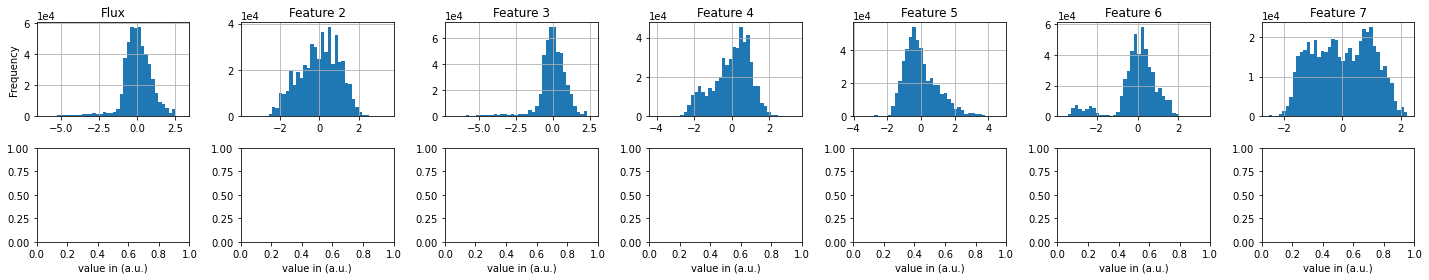

Next, we want to start the training process, i.e. training SCINet on the dataset. For more instructions on how the training works, follow the instructions in the training_scinet.ipynb notebook. The number of training epochs is by defauklt set to 150 and the hyperparameters are corresponding with the original set of hyperparameters from the original code:

https://github.com/cure-lab/SCINet/blob/main/Appendix/Appendix.pdf

Note that the number of training epochs for now is set to 10 in order to see how the results will follow. The paper sets the number of epochs by default to a maximum of 150. Make sure that in train_scinet the patience of the 'callback.EarlyStopping' is turned off for 150 training epochs, because it otherwise stops after the validation loss has been decreasing for the past 25 epochs. 

In [3]:
#================ Training ====================

EPOCHS = 10
BATCH_SIZE = 8
HID_SIZE = 4
NUM_LEVELS = 3
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.003
PROBABILISTIC = False


  3%|▎         | 353/10379 [00:00<00:02, 3529.81it/s]

Starting data preprocessing...
   5.827000141  2.009000063  1.598999977  0.462000012  4.203000069  \
0        5.693        2.076        1.492        0.426        4.142   
1        5.157        1.741        1.279        0.355        3.777   
2        5.090        1.942        1.279        0.391        3.807   
3        5.358        1.942        1.492        0.462        3.868   
4        5.626        2.143        1.528        0.533        4.051   

   1.340000033  30.53100014  
0        1.371    27.787001  
1        1.218    27.787001  
2        1.279    25.044001  
3        1.279    21.948000  
4        1.371    21.174000   (17419, 7)
Making train/validation/test splits...
Making samples...


100%|██████████| 10379/10379 [00:03<00:00, 3345.66it/s]
d:\Master 2\ADL\Definitive_version\SCINet\exp\reprod\preprocess_data.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)
 23%|██▎       | 770/3412 [00:00<00:00, 3753.52it/s]

Making samples...


 23%|██▎       | 769/3412 [00:00<00:00, 3837.38it/s]

Making samples...


100%|██████████| 3412/3412 [00:01<00:00, 3111.09it/s]


Making X-y splits...
===========================[SCINET]=====================================
Initializing training with data:
X_train: (10150, 48, 7), y_train: (10150, 24, 7)
X_val: (3407, 48, 7), y_val: (3407, 24, 7)
X_test: (3410, 48, 7), y_test: (3410, 24, 7)
Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 Block_0 (SCINet)            (None, 24, 7)             97332     
                                                                 
Total params: 97,332
Trainable params: 97,332
Non-trainable params: 0
_________________________________________________________________
None
Is null X: 0
Is null y: 0
Epoch 1/10
1269/1269 [==============================] - 46s 22ms/step - loss: 0.8551 - val_loss: 0.7232
Epoch 2/10
1269/1269 [==============

# Results 

In order to see whether our training and validation loss meet the results from the original paper, we need to set a target. The targets for MAEs of the corresponding datasets can be found in table 2 in the original paper.

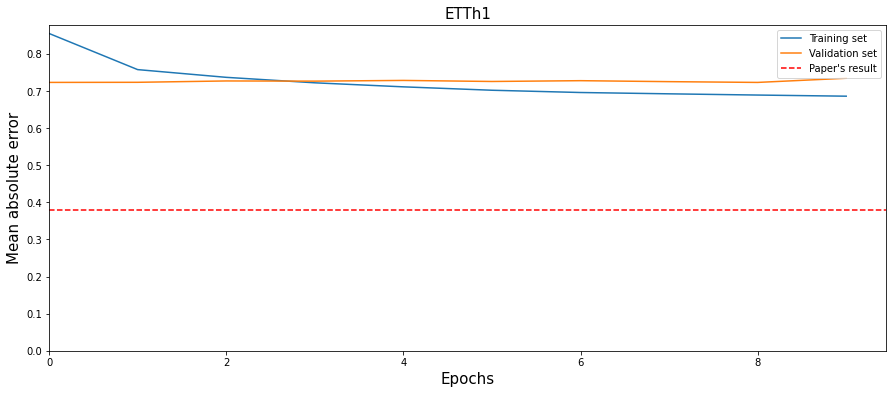

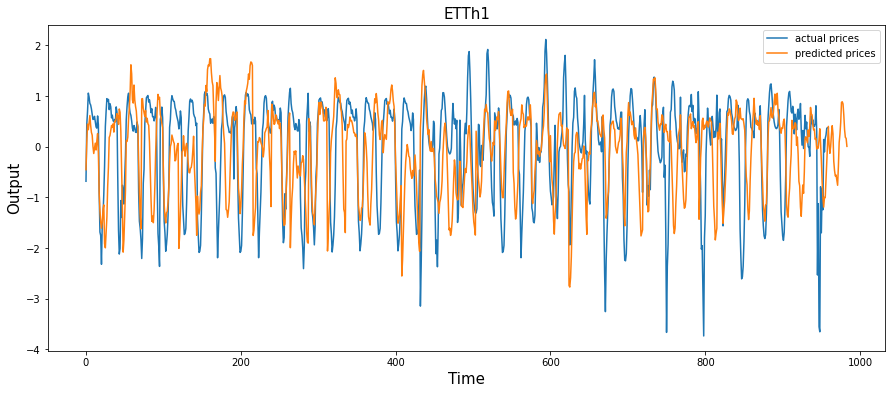

In [4]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
target = 0.379 #value of MAE of paper

X = np.arange(len(train_loss))

plt.figure(figsize=(15,6))
plt.plot(X, train_loss, label='Training set')
plt.plot(X, val_loss, label="Validation set")
plt.axhline(y=target, color='r', linestyle='--', label="Paper's result")
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean absolute error', fontsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.title('ETTh1', fontsize=15)
plt.legend()
plt.show()

output = model(X_test)

series = 0
total_timesteps = 1000

X_time_blocks = math.floor( total_timesteps / X_LEN )
Y_time_blocks = math.floor( total_timesteps / Y_LEN )

actual_prices = np.array([])
for t in range(X_time_blocks):
    actual_prices = np.append(actual_prices, X_test[t*X_LEN,:,series])

predicted_prices = np.array([])
for t in range(Y_time_blocks):
    predicted_prices = np.append(predicted_prices, np.array(output[t*Y_LEN])[:,series])

X_times = np.arange(len(actual_prices))
Y_times = np.arange(len(predicted_prices))
plt.figure(figsize=(15,6))
plt.plot(X_times, actual_prices, label='actual prices')
plt.plot(Y_times, predicted_prices, label='predicted prices')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Output', fontsize=15)
plt.title('ETTh1', fontsize=15)
plt.legend()
plt.show()

# Leaky normalization

In order to truly compare our results with the original results from the paper, we have to compare it with the normalization method the paper uses. The paper uses a leaky normalization which can cause faulty values for the loss and therefore faulty predictions.

The code used in the paper normalizes the data by considering the entire feature column and normalizing this, see: https://github.com/cure-lab/SCINet/blob/c41c0a7303b79f2641ae213a596dedb609875367/data_process/financial_dataloader.py#L38 for the direct implementation. The code supports several normalization methods which all take the following steps: normalize the entire data set, create samples and split the data in a train- and test set. This is not a legitimate way to normalize the data, since the $y$ part of the data is also used to calculate the mean and standard deviation for normalization. Instead, one should use the $X$ part of the data only to normalize the $X$ and $y$ part of the data.

If we turn 'leaky' to True in standardization_settings(), the normalization method of the original paper is turned off and we can compare the results.

In [5]:
#============= Preprocessing ==============

#data_format = ["timestamp","open","high","low","close","volume",]
data_format = ["price"]
                    
fraction_used = 1
train_frac = 0.6
val_frac = 0.2
test_frac = 0.2

X_LEN = 48
Y_LEN = 24
RANDOM_SEED = 4321#None
OVERLAPPING = True
STANDARDIZE = True

standardization_settings = {'per_sample': True,
                            'leaky': True,
                            'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

#df = pd.read_csv(os.path.dirname(os.path.dirname(cwd+'/data/Data_preprocessed/ETTh1.csv'))).dropna()
df = pd.read_csv(f"exp/reprod/data/Data_preprocessed/ETTh1.csv").dropna()
df = df.swapaxes("index", "columns")

data = {}
for idx, pair in enumerate(pairs):
    data[pair] = df.iloc[idx]

In [6]:
#================ Training ====================

EPOCHS = 10
BATCH_SIZE = 8
HID_SIZE = 4
NUM_LEVELS = 3
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.003
PROBABILISTIC = False

# Process data:
results = preprocess(   data = data, 
                        symbols = pairs,
                        data_format = data_format,
                        fraction = fraction_used,
                        train_frac = train_frac,
                        val_frac = val_frac,
                        test_frac = test_frac,
                        X_LEN = X_LEN,
                        Y_LEN = Y_LEN,
                        OVERLAPPING = OVERLAPPING,
                        STANDARDIZE = STANDARDIZE,
                        standardization_settings = standardization_settings
                        )

model, history, X_train , y_train, X_val, y_val, X_test_leaky, y_test = train_scinet( X_train = results["X_train"].astype('float32'),
                                                                                y_train = results["y_train"].astype('float32'),
                                                                                X_val = results["X_val"].astype('float32'),
                                                                                y_val = results["y_val"].astype('float32'),
                                                                                X_test = results["X_test"].astype('float32'),
                                                                                y_test = results["y_test"].astype('float32'),
                                                                                epochs = EPOCHS,
                                                                                batch_size = BATCH_SIZE,
                                                                                X_LEN = X_LEN,
                                                                                Y_LEN = [Y_LEN],
                                                                                output_dim = [results["X_train"].shape[2]],
                                                                                selected_columns = None,
                                                                                hid_size= HID_SIZE,
                                                                                num_levels= NUM_LEVELS,
                                                                                kernel = KERNEL_SIZE,
                                                                                dropout = DROPOUT,
                                                                                loss_weights= [1],
                                                                                learning_rate = LEARNING_RATE,
                                                                                probabilistic = PROBABILISTIC)



  4%|▍         | 400/10379 [00:00<00:02, 3995.42it/s]

Starting data preprocessing...
   5.827000141  2.009000063  1.598999977  0.462000012  4.203000069  \
0        5.693        2.076        1.492        0.426        4.142   
1        5.157        1.741        1.279        0.355        3.777   
2        5.090        1.942        1.279        0.391        3.807   
3        5.358        1.942        1.492        0.462        3.868   
4        5.626        2.143        1.528        0.533        4.051   

   1.340000033  30.53100014  
0        1.371    27.787001  
1        1.218    27.787001  
2        1.279    25.044001  
3        1.279    21.948000  
4        1.371    21.174000   (17419, 7)
Making train/validation/test splits...
Making samples...


100%|██████████| 10379/10379 [00:03<00:00, 3218.65it/s]
d:\Master 2\ADL\Definitive_version\SCINet\exp\reprod\preprocess_data.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)
 12%|█▏        | 394/3412 [00:00<00:00, 3912.69it/s]

Making samples...


 11%|█▏        | 387/3412 [00:00<00:00, 3839.33it/s]

Making samples...


100%|██████████| 3412/3412 [00:00<00:00, 3796.05it/s]


Making X-y splits...
===========================[SCINET]=====================================
Initializing training with data:
X_train: (10150, 48, 7), y_train: (10150, 24, 7)
X_val: (3407, 48, 7), y_val: (3407, 24, 7)
X_test: (3410, 48, 7), y_test: (3410, 24, 7)
Building model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 Block_0 (SCINet)            (None, 24, 7)             97332     
                                                                 
Total params: 97,332
Trainable params: 97,332
Non-trainable params: 0
_________________________________________________________________
None
Is null X: 0
Is null y: 0
Epoch 1/10
1269/1269 [==============================] - 45s 22ms/step - loss: 0.8555 - val_loss: 0.7283
Epoch 2/10
1269/1269 [============

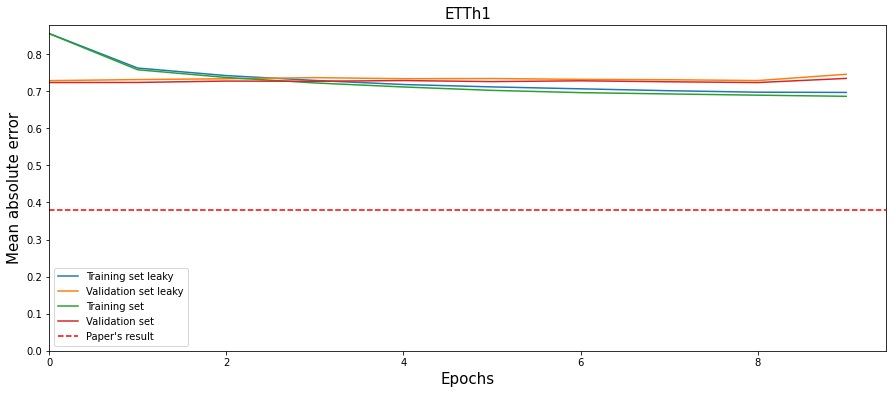

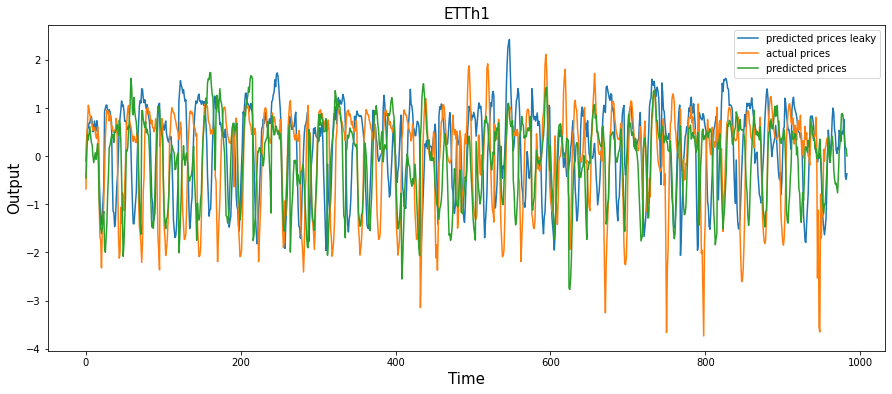

In [7]:
train_loss_leaky = history.history['loss']
val_loss_leaky = history.history['val_loss']
target = 0.379 #value of MAE of paper

X = np.arange(len(train_loss_leaky))

plt.figure(figsize=(15,6))
plt.plot(X, train_loss_leaky, label='Training set leaky')
plt.plot(X, val_loss_leaky, label="Validation set leaky")
plt.plot(X, train_loss, label='Training set')
plt.plot(X, val_loss, label="Validation set")
plt.axhline(y=target, color='r', linestyle='--', label="Paper's result")
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean absolute error', fontsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.title('ETTh1', fontsize=15)
plt.legend()
plt.show()

output_leaky = model(X_test_leaky)

series = 0
total_timesteps = 1000

X_time_blocks = math.floor( total_timesteps / X_LEN )
Y_time_blocks = math.floor( total_timesteps / Y_LEN )


predicted_prices_leaky = np.array([])
for t in range(Y_time_blocks):
    predicted_prices_leaky = np.append(predicted_prices_leaky, np.array(output_leaky[t*Y_LEN])[:,series])

Y_times_leaky = np.arange(len(predicted_prices_leaky))
plt.figure(figsize=(15,6))
plt.plot(Y_times_leaky, predicted_prices_leaky, label='predicted prices leaky')
plt.plot(X_times, actual_prices, label='actual prices')
plt.plot(Y_times, predicted_prices, label='predicted prices')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Output', fontsize=15)
plt.title('ETTh1', fontsize=15)
plt.legend()
plt.show()

As we can see, the loss for the leaky normalization differs from our normalization method and therefore, the predicted price also differ from each other.